# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №5 - Алгоритмы кластеризации


###### <hr\>
**Общая информация**

**Срок сдачи:** 17 декабря 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 17 декабря, -4 балла после 06:00 24 декабря, -6 баллов после 06:00 31 декабря -8 баллов  после 06:00 7 января


Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

**Из чего состоит задание:**

###### Теоретические вопросы (2 балла)

###### Реализация алгоритма кластеризации (6 баллов)

###### Боевое применение (2 балла)




**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл

# Определяем, что вам досталось

Укажите свою фамилию на русском языке в поле ниже.

In [ ]:
import hashlib

def lucky_hash(text):
    return int(hashlib.md5(text.encode('utf-8')).hexdigest()[:8], 16) 

USER_NAME = u"Гарькавый".lower()

ALGORITHMS = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - число кластеров)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - число кластеров, linkage)",]

print ("Имплементируйте алгоритм кластеризации %s"\
% (
    ALGORITHMS[lucky_hash(USER_NAME[::-1]) % 2]
) )

Не стоит переживать из-за Вашего варианта. Технически оба алгоритма несложно реализовать.  EM алгоритма бояться не стоит, Вам будет нужно просто реализовать уже выведенные формулы для E и M шагов.

In [1]:
import time
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Теоретическое введение


Основная задача кластерного анализа — разбиение исходного набора объектов на группы (кластеры) таким образом, чтобы объекты в группе были похожи друг на друга, а объекты из разных групп - отличались. 

В этой работе мы будем реализовывать один из двух популярных методов кластеризации: разделение смеси нормальных распределений или агломеративную кластеризацию. 

## Смесь нормальных распределений



Предполагаем, что наши данные порождены смесью $k$ нормальных распределений, то есть 

$$ p(\mathbf{x}) = \sum_k \pi_k \mathcal{N}(\mathbf{x} | \mathbf{\mu}_k, \mathbf{\Sigma}_k) $$,


где $\mathcal{N}$ - многомерное нормальное распределение размерности ${D}$:

$$\mathcal{N(\mathbf{x} | \mathbf{\mu}, \mathbf{\Sigma}}) = \frac{1}{(2 \pi)^{D/2}} \frac{1}{|\mathbf{\Sigma}|^{1/2}} \exp \left\{-\frac{1}{2}(\mathbf{x} - \mathbf{\mu})^T \mathbf{\Sigma^{-1}} (\mathbf{x} - \mathbf{\mu})\right\}$$

**Параметры**  


${D}$-мерный вектор средних

$$\mathbf{\mu}$$

$D \times D$-мерная матрица ковариации   (симметричная)


$$\mathbf{\Sigma} = E[(\mathbf{x} - \mathbf{\mu})(\mathbf{x} - \mathbf{\mu})^T]$$



Необходимо оценить параметры $\pi_k, \mathbf{\mu_k}, \mathbf{\Sigma_k} $ для всех компонент смеси.  Сделать это можно с помощью EM алгоритма - алгоритма, который находит оценку максимального правдоподобия в задаче со скрытыми переменными. 

## Expectation Maximization

**I** До цикла проинциализировать случайно  $\mu_k, \Sigma_k, \pi_k$ ($\pi_k$ должны суммироваться в 1)

**E** Expectation: при фиксированных $\mu_k, \Sigma_k, \pi_k$
$$
p(z_k = 1| x_n ) = \gamma(z_{nk}) = \frac{\pi_k \mathcal{N} (\mathbf{x}_n | \mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j \mathcal{N} (\mathbf{x}_n | \mu_j, \Sigma_j)}
$$
**M** Maximization: при фиксированных $\gamma(z_{nk})$
$$
N_k = \sum_{n=1}^N \gamma(z_{nk}), \;\; \mu_k = \frac 1 {N_k} \sum_{n=1}^N \gamma(z_{nk}) \mathbf{x}_n
$$
$$
\Sigma_k = \frac 1 {N_k} \sum_{n=1}^N \gamma(z_{nk}) (\mathbf{x}_n - \mu_k)(\mathbf{x}_n - \mu_k)^T
$$
$$
\pi_k = \frac{N_k}{N}
$$
**S** Остановиться при достижении сходимости

Номер кластера для $n$ объекта будем брать по принципу maximum a-posteriori, то есть относить объект к тому кластеру, у которого максимальна апостериорная вероятность:
$$ k_n =  \arg\underset{k}\max  p(z_k = 1| x_n ) =  \arg\underset{k}\max \gamma(z_{nk}) $$

## Агломеративная кластеризация

Иерархические алгоритмы кластеризации строят на выборке систему вложенных разбиений.  Наиболее часто испоьзуемые иерархические алгоритмы - агломеративные алгоритмы, которые строят ирархию по восходящей, то есть от момента, когда все элементы являются отдельными кластерами, до того момента, пока вся выборка не станет одним кластером.

Сам алгоритм описать можно примерно так:

* начинаем с ситуации, когда каждый объект - отдельный кластер
* на каждом шаге совмещаем два наиболее близких кластера
* останавливаемся, когда получаем требуемое количество или единственный кластер


В данной работе Вам предлагается реализовать три варианта расстояний между кластерами, по которым Вы определяете пару для слияния: 
* Single linkage
$$ d_{min}(C_i, C_j) = \min_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Complete linkage
$$ d_{max}(C_i, C_j) = \max_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Average linkage
$$ d_{avg}(C_i, C_j) = \frac{1}{n_i n_j}\sum_{\mathbf{x} \in C_i}\sum_{\mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

Для простоты будем использовать евклидово расстояние между объектами.



Для того, чтобы на втором этапе нам не пересчитывать заново расстояния между всеми парами кластеров, можно использовать Формулы Ланса-Вильямса, которые позволяют посчитать расстояние между кластерами после объединения, используя только расстояния между кластерами до объедения.  Таким образом, достаточно будет посчитать расстояния только между всеми одноэлементными кластерами (первый этап), а затем пересчитывать расстояния при их объединении через 
формулы Ланса-Вильямса. 

Общая  формула выглядит так:
$$ d(C_i \cup C_j, C_k) = a_i \cdot d(C_i, C_k) + a_j \cdot d(C_j, C_k) + b \cdot d(C_i, C_j) + c \cdot |d(C_i, C_k) - d(C_j, C_k)|$$

Можно показать, что все относительно разумные кластерные расстояния можно описать данной формулой. 

Для интересущих нас linkage:

* single-linkage       $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =  - \frac{1}{2} $

* complete-linkage     $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =   \frac{1}{2} $

* average-linkage       $a_i = \frac{|C_i|}{|C_i \cup C_j|}, a_j =  \frac{|C_j|}{|C_i \cup C_j|}, b = 0, c = 0 $



# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Сходимость kmeans.

Метод kmeans является частным случаем EM алгоритма и наиболее простым в обосновании сходимости. Докажите, что kmeans всегда сходится, и итераций не будет превышать $k^N$, где $k$ $-$ число кластеров, $N$ $-$ число объектов

Подсказка: Вам стоит рассмотреть функционал, который минимизирует алгоритм, и подумать, как он изменяется на E шаге и на M шаге.



***Ваше решение здесь***

Задача 2. Сходимость EM.

Разобравшись со сходимостью kmeans, можно догадаться и до ответа про EM алгоритм.

При каком условии на правдоподобие системы EM алгоритм будет  сходиться?



***Ваше решение здесь***

Задача 3. Формулы Ланса-Вильямса.

Формулы Ланса-Вильямса крайне удобны для быстрого пересчта расстояний в агломеративной кластеризации. Давайте докажем  формулы для single и complete linkage. 

Докажите, что:

$d_{\min}(U \cup V, S) = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) |  $


$d_{\max}(U \cup V, S) = \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} | d_{\max}(U, S) - d_{\max}(V, S) |  $




***Ваше решение здесь***

1.

2.

3.
$|a - b| =
  \begin{cases}
    a - b, & a \ge b \\
    b - a, & a \le b 
  \end{cases}$
 
$\quad$ Выразим min через модуль:

$\quad$ 1) Распишем a и b таким образом:

$b = \frac{1}{2} (a + b) - \frac{1}{2} (a - b), \quad a \ge b$

$a = \frac{1}{2} (a + b) - \frac{1}{2} (b - a), \quad a \le b$

$\quad$ Обобщим для обоих случаев:

$\min(a, b) = \frac{1}{2} (a + b) - \frac{1}{2} |a - b| $

$\quad$ 2) Выразим max через модуль:

$\quad$ Распишем a и b таким образом:

$a = \frac{1}{2} (a + b) + \frac{1}{2} (a - b), \quad a \ge b$

$b = \frac{1}{2} (a + b) + \frac{1}{2} (b - a), \quad a \le b$

$\quad$ Обобщим для обоих случаев:

$\max(a, b) = \frac{1}{2} (a + b) + \frac{1}{2} |a - b| $

$\quad$ 3) Из определения $d_{\min}$, $d_{\max}$ следует:

$d_{\min}(U \cup V, S) = \min\{d_{\min}(U, S), d_{\min}(V, S)\} $

$d_{\max}(U \cup V, S) = \max\{d_{\max}(U, S), d_{\max}(V, S)\} $

Выразим здесь $\min$, $\max$ через модуль и получим данные в задаче формулы.

# Реализация алгоритма кластеризации  (6 баллов)

Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`. 

In [7]:
def pdist_idx(i, j, n):
    """
    return index for distance between X[i] and X[j] in "pdist(X) + [0]", where len(X) == n
    """
    if i == j:
        return -1
    I, J = (i, j) if i < j else (j, i)
    return ((2 * n - I - 3) * I) // 2 + J - 1

def pdist_row_gen(i, n):
    """
    generate all indices of "i-th row/column" in pdist condensed matrix
    """
    idx = i - 1
    d = n - 1
    for _ in range(i):
        d -= 1
        yield idx
        idx += d
    yield -1
    yield from range(idx + 1, idx + n - i)

def pdist_row(i, n):
    return np.array(list(pdist_row_gen(i, n)))

def pdist_rowcol(k, n):
    import math

    def calc_row_idx(k, n):
        return int(math.ceil((1 / 2.) * (- (-8 * k + 4 * n ** 2 - 4 * n - 7) ** 0.5 + 2 * n - 1) - 1))

    def elem_in_i_rows(i, n):
        return i * (n - 1 - i) + (i*(i + 1))/2

    def calc_col_idx(k, i, n):
        return int(n - elem_in_i_rows(i + 1, n) + k)

    i = calc_row_idx(k, n)
    j = calc_col_idx(k, i, n)
    return i, j

In [8]:
from sklearn.base import BaseEstimator, ClusterMixin
from scipy.spatial.distance import pdist
from sklearn.metrics import pairwise_distances

class Clustering(BaseEstimator, ClusterMixin):
    """
    My agglomerative clustering algorithhm 
    """

    def __init__(self, n_clusters=2, linkage="single"):
        self.n_clusters = n_clusters
        if linkage == "single":
            self.linkage = self.linkage_single
            self.linkage_coefs = self.linkage_coefs_single
        elif linkage == "complete":
            self.linkage = self.linkage_complete
            self.linkage_coefs = self.linkage_coefs_complete
        elif linkage == "average":
            self.linkage = self.linkage_average
            self.linkage_coefs = self.linkage_coefs_average

    def linkage_single(self, X, mask_i, mask_j, dists=None):
        if dists is None:
            dists = pairwise_distances(X[mask_i], X[mask_j])
        return dists.min()

    def linkage_complete(self, X, mask_i, mask_j, dists=None):
        if dists is None:
            dists = pairwise_distances(X[mask_i], X[mask_j])
        return dists.max()

    def linkage_average(self, X, mask_i, mask_j, dists=None):
        if dists is None:
            dists = pairwise_distances(X[mask_i], X[mask_j])
        return dists.mean()

    def linkage_coefs_single(self, k, l):
        return 0.5, 0.5, 0, -0.5

    def linkage_coefs_complete(self, k, l):
        return 0.5, 0.5, 0, 0.5

    def linkage_coefs_average(self, k, l):
        union_sum = np.any(self.clusters[[k, l]], axis=0).sum()
        return self.clusters[k].sum() / union_sum, \
            self.clusters[l].sum() / union_sum, 0, 0

    def fit(self, X, y=None):
        """
        Use data matrix X to compute model parameters
        """
        self.X_len = len(X)
        cur_n = self.X_len
        self.clusters = np.identity(self.X_len, dtype=bool)
        dists = np.append(pdist(X), 0.)
        iter_n = 0
        while cur_n > self.n_clusters:
            iter_n += 1
            # индексы ближайших друг к другу кластеров в self.clusters
            k, l = pdist_rowcol(dists[:-1].argmin(), cur_n)
            k, l = (k, l) if k < l else (l, k)
            # merge(k, l)
            # на самом деле, надо в матрице squareform(pdist[:-1]):
            # 1) взять строки k и l
            # 2) заменить строку k на функцию от строк k и l по ф-ле Ланса-Вильямса
            # 3) сделать то же самое со столбцами вместо строк
            # 4) удалить строку и столбец l
            # но это все производится на уплотненной матрице pdist[:-1] вместо квадратной матрицы
            a_k, a_l, b, c = self.linkage_coefs(k, l)
            d_kl = dists[pdist_idx(k, l, cur_n)]
            d_k_idx = pdist_row(k, cur_n)
            d_l_idx = pdist_row(l, cur_n)
            dists[pdist_row(k, cur_n)] = (
                a_k * dists[d_k_idx]
                + a_l * dists[d_l_idx]
                + b * d_kl
                + c * np.abs(dists[d_k_idx] - dists[d_l_idx])
            )
            # нуль в конце не удаляем
            dists = np.delete(dists, d_l_idx[d_l_idx >= 0])
            self.clusters[k] = np.any(self.clusters[[k, l]], axis=0)
            self.clusters = np.delete(self.clusters, l, axis=0)
            cur_n -= 1
            # проверка матрицы расстояний
#             if cur_n - self.n_clusters <= 5:
#                 dists2 = []
#                 for i in range(cur_n):
#                     for j in range(i + 1, cur_n):
#                         dists2.append(self.linkage(X, self.clusters[i], self.clusters[j]))
#                 dists2.append(0.)
#                 dists2 = np.array(dists2)
#                 print('mean error:', np.abs(dists - dists2).mean())
        self.labels_ = np.zeros(self.X_len, dtype=int)
        for k in range(self.n_clusters):
            self.labels_[self.clusters[k]] = k
        return self
    
    def predict(self, X):
        """
        Using computed model parameters predict cluster
        for all objects from X
        """
        # переделать на случай если X это не тот самый X, на котором обучались
        return self.labels_

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

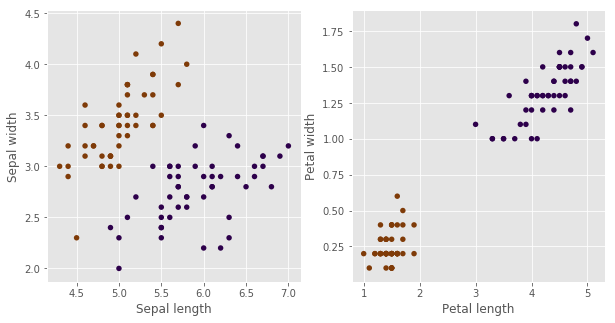

In [9]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [10]:
%time pred_iris = Clustering(n_clusters=2, linkage="average").fit_predict(x_iris)
# pred_iris = [ 0 ] * len(y_iris)
print ("Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris))

CPU times: user 31.8 ms, sys: 287 µs, total: 32.1 ms
Wall time: 31 ms
Adjusted Rand index for iris is: 1.00


In [11]:
pred_iris

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [12]:
# Давайте проверим, как справляются sklearn реализации
sklearn_gmm = GaussianMixture(n_components=2)
gmm_t0 = time.time()
sklearn_gmm.fit(x_iris)
gmm_diff = time.time() - gmm_t0
gmm_score = smt.adjusted_rand_score(y_iris, sklearn_gmm.predict(x_iris))

sklearn_aggl = AgglomerativeClustering(n_clusters=2)
aggl_t0 = time.time()
aggl_pred = sklearn_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print ("GMM score {}. GMM time {}. AGGL score {}. AGGL time {}".format(gmm_score, gmm_diff, aggl_score, aggl_diff))

GMM score 1.0. GMM time 0.007822275161743164. AGGL score 1.0. AGGL time 0.004064321517944336


In [13]:
sklearn_gmm = GaussianMixture(n_components=2)
%time sklearn_gmm.fit(x_iris)
gmm_score = smt.adjusted_rand_score(y_iris, sklearn_gmm.predict(x_iris))

sklearn_aggl = AgglomerativeClustering(n_clusters=2)
%time aggl_pred = sklearn_aggl.fit_predict(x_iris)
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)

CPU times: user 6.6 ms, sys: 0 ns, total: 6.6 ms
Wall time: 7.4 ms
CPU times: user 652 µs, sys: 0 ns, total: 652 µs
Wall time: 657 µs


Сверьте Ваш алгоритм с этими числами. Уверен, что у Вас получится не хуже!

# Боевое применение (2  балла)


Алгоритмы кластеризации прекрасны тем, что они позволяют быстро понять, как устроены наши данные. Давайте применим Ваш алгоритм для анализа реальной задачи!

Важное замечание: в этой части задания студенту самому предлагается разобраться с данными и их форматом в качестве полезного упраженения. Не принимайте это близко к сердцу :)

Ввозьмем датасет различных стран.  
Данные нужно скачать тут https://data.worldbank.org/data-catalog/world-development-indicators.   


Подход следующий: фиксируем год, для каждой страны берём индикаторы по зафиксированному году, кластеризуем по индикаторам. 
Разбиение должно быть объяснимым, в противном случае, скорее всего нужно лучше настроить параметры кластеризации.   

Необходимо показать, какие страны попали в общий кластер в и объяснить из-за каких признаков это произошло. Если страны были в одном кластере, а спустя несколько лет разъехались по разным кластерам, попробуйте это объяснить. 

In [14]:
# Место для Вашего кластерного анализа

In [15]:
df = pd.read_csv("WDI_csv/WDIData.csv")

In [16]:
years = range(1960, 2017+1)
n_years = len(years)
countries_groupby = df.groupby("Country Code")
contries_codes_names = df[["Country Code", "Country Name"]].drop_duplicates().values
country_code2name_dict = dict(contries_codes_names)
country_name2code_dict = dict(contries_codes_names[:, ::-1])
country_code2name = lambda code: country_code2name_dict[code]
country_name2code = lambda name: country_code2name_dict[name]
country_codes2names = np.vectorize(lambda code: country_code2name_dict[code])
country_names2codes = np.vectorize(lambda name: country_code2name_dict[name])
countries = contries_codes_names[:, 0]
n_countries = len(countries)
indicators = countries_groupby.get_group(countries[0])["Indicator Code"].values
n_indicators = len(indicators)

In [17]:
df_years = []
for year in years:
    df_year_countries = []
    for country in countries:
        df_year_country = pd.DataFrame(columns=[country], index=indicators, data=countries_groupby.get_group(country)[str(year)].values).transpose()
        df_year_countries.append(df_year_country)
    df_year = pd.concat(df_year_countries, sort=False)
    df_years.append(df_year)

In [19]:
columns_set = set(df_years[0].columns)
always_na = set(df_years[0].columns)
always_non_na = set(df_years[0].columns)
for year_idx in range(n_years):
    non_na = set(df_years[year_idx].dropna(how='all', axis=1).columns)
    always_non_na &= non_na
    na = columns_set - non_na
    always_na &= na
    print(len(always_na), len(always_non_na))
print(always_na, "\n")
print(always_non_na)

1197 403
1155 396
1135 392
1130 392
1129 392
1124 392
1124 390
1124 390
1122 390
1114 390
729 390
725 390
686 390
686 390
685 390
679 390
673 390
666 390
666 390
657 390
632 390
630 390
630 390
625 390
608 390
598 390
594 390
592 390
571 390
566 390
444 390
398 390
394 390
393 390
382 390
355 390
351 390
343 390
301 390
276 390
207 390
200 390
182 390
166 390
149 390
107 390
91 390
75 390
70 390
60 390
57 390
45 390
42 390
37 390
28 389
24 371
18 358
0 283
set() 

{'SP.POP.DPND', 'SL.TLF.CACT.FE.NE.ZS', 'BM.GSR.TRAN.ZS', 'NV.AGR.TOTL.CD', 'SP.POP.4549.MA.5Y', 'SL.UEM.1524.NE.ZS', 'NV.FSM.TOTL.KN', 'BM.GSR.TOTL.CD', 'NE.RSB.GNFS.CN', 'SL.EMP.TOTL.SP.MA.NE.ZS', 'SP.POP.3539.MA.5Y', 'SL.UEM.1524.MA.NE.ZS', 'SP.POP.65UP.TO.ZS', 'NE.IMP.GNFS.KN', 'SP.POP.5054.FE.5Y', 'NE.EXP.GNFS.KD', 'TX.VAL.SERV.CD.WT', 'NE.GDI.FTOT.KN', 'NY.GDP.FCST.CN', 'NY.GDP.PCAP.CN', 'SP.POP.DPND.OL', 'NV.IND.TOTL.ZS', 'NY.GNP.PCAP.CN', 'NE.RSB.GNFS.ZS', 'NY.GDP.FCST.KN', 'SP.POP.1564.MA.ZS', 'NE.CON.PRVT.CN', 'SL.T

In [20]:
from itertools import permutations
from sklearn.metrics import mean_absolute_error as mae

def enum_clusters(labels_new, labels_old, year_new_idx, n_clusters):
    """
    постараться перенумеровать новый набор кластеров так,
    чтобы была прямая связь со старым набором кластеров
    """
#     groupby_new = df_years[year_new_idx].fillna(0).groupby(labels_new)
#     groupby_old = df_years[year_new_idx - 1].fillna(0).groupby(labels_old)
#     mean_new = groupby_new.mean()
#     mean_old = groupby_old.mean()
#     mean_new["cluster_size"] = groupby_new.size() * n_indicators
#     mean_old["cluster_size"] = groupby_old.size() * n_indicators
    perm_list = list(map(list, permutations(range(n_clusters))))
#     perm_diffs = np.array(list(map(lambda perm:
#                           mae(mean_new.values[perm], mean_old.values),
#                           perm_list)))
    # матрица попарных пересечений кластеров из старого и нового разбиений
    intersects = np.zeros((n_clusters, n_clusters))
    for i in range(n_clusters):
        for j in range(n_clusters):
            mask_i = labels_old == i
            mask_j = labels_new == j
            intersects[i, j] = (mask_i & mask_j).sum() / (mask_i.sum() + mask_j.sum())
    perm_intersects = np.array(list(map(lambda perm:
                          np.array([intersects[k, l]
                                   for k, l in zip(perm, range(n_clusters))]).mean(),
                          perm_list)))
#     best_perm_idx = np.argmin(perm_diffs)
    best_perm_idx = np.argmax(perm_intersects)
#     print(perm_diffs.min(), perm_diffs.max(), perm_diffs.mean())
#     best_perm_idx = np.argmin(perm_diffs / perm_diffs.max() + 10 * (1 - perm_intersects))
    best_perm = perm_list[best_perm_idx]
    print(best_perm)
    if best_perm != list(range(n_clusters)):
        rename_labels = np.vectorize(lambda x: best_perm[int(x)])
        return rename_labels(labels_new)
    else:
        return labels_new

In [129]:
n_clusters = 9
drop_non_countries = False
countries_start = 47 if drop_non_countries else 0
clusters_labels_raw = np.zeros((n_years, n_countries - countries_start))
todrop = set(indicators) - always_non_na
nan_ratio_thres = 0.8
for i in range(n_years):
    df_ = df_years[i].iloc()[countries_start:]
    df_ = df_.drop(todrop, axis=1)
    df_ = df_.dropna(how='all', axis=1)
#     print(df_.info())
#     for col in df_.columns:
#         nan_ratio = df_[col].isnull().sum() / df_.shape[1]
#         print("{0:<4.2}".format(1 - nan_ratio), end=" ")
    nan_ratios = df_.isnull().sum(axis=0) / df_.shape[1]
    df_ = df_.drop(df_.columns[nan_ratios >= nan_ratio_thres], axis=1)
    df_ = df_.fillna(df_.mean())
    X = df_.values
#     print(X.std(axis=0))
    X = ((X - X.mean(axis=0)) / X.std(axis=0))
    X = np.nan_to_num(X)
#     aggl = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
    aggl = Clustering(n_clusters=n_clusters, linkage="complete")
    aggl_pred = aggl.fit_predict(X)
    clusters_labels_raw[i] = aggl_pred

/home/garx/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/home/garx/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


In [130]:
clusters_labels = clusters_labels_raw.copy()

In [131]:
# в каждом году номера кластеров переставляются так, чтобы соответствовать предыдущему году
# но т.к. для каждого года рассматриваются всевозможные перестановки номеров кластеров,
# то сложность этой операции факториальная :D
# (для n_clusters=5-6 - почти сразу, для n_clusters=9 - 2 минуты)
for i in range(1, n_years):
#     clusters_labels[i] = 
    print('{:<5}'.format(f"{years[i]}:"),end="")
    clusters_labels[i] = enum_clusters(clusters_labels[i], clusters_labels[i - 1], i, n_clusters)

1961:[0, 1, 2, 3, 4, 5, 6, 7, 8]
1962:[0, 5, 1, 2, 3, 4, 6, 7, 8]
1963:[0, 5, 1, 2, 3, 4, 6, 7, 8]
1964:[0, 5, 1, 2, 3, 4, 6, 7, 8]
1965:[0, 1, 2, 3, 4, 5, 6, 7, 8]
1966:[0, 1, 2, 3, 4, 5, 6, 7, 8]
1967:[0, 1, 3, 4, 5, 6, 2, 7, 8]
1968:[0, 1, 3, 5, 4, 6, 2, 7, 8]
1969:[0, 1, 3, 5, 4, 7, 6, 2, 8]
1970:[0, 2, 1, 3, 4, 6, 5, 7, 8]
1971:[0, 2, 3, 7, 4, 6, 5, 1, 8]
1972:[0, 2, 3, 7, 4, 6, 5, 1, 8]
1973:[0, 3, 2, 7, 4, 6, 5, 1, 8]
1974:[0, 2, 3, 7, 4, 6, 5, 1, 8]
1975:[0, 2, 3, 7, 4, 6, 5, 1, 8]
1976:[0, 2, 3, 7, 4, 6, 5, 1, 8]
1977:[0, 2, 3, 7, 4, 6, 5, 1, 8]
1978:[0, 2, 3, 7, 1, 4, 6, 5, 8]
1979:[0, 2, 3, 7, 1, 4, 6, 5, 8]
1980:[0, 3, 7, 1, 4, 6, 5, 2, 8]
1981:[0, 3, 7, 1, 4, 6, 5, 2, 8]
1982:[0, 3, 2, 7, 1, 4, 6, 5, 8]
1983:[0, 7, 3, 2, 1, 4, 6, 5, 8]
1984:[0, 2, 3, 7, 1, 4, 6, 5, 8]
1985:[0, 7, 3, 2, 1, 4, 6, 5, 8]
1986:[0, 2, 3, 7, 1, 4, 6, 5, 8]
1987:[0, 3, 2, 7, 1, 4, 6, 5, 8]
1988:[0, 3, 2, 7, 1, 4, 6, 5, 8]
1989:[0, 2, 3, 7, 1, 4, 6, 5, 8]
1990:[0, 3, 7, 2, 1, 4, 6, 5, 8]
1991:[0, 3

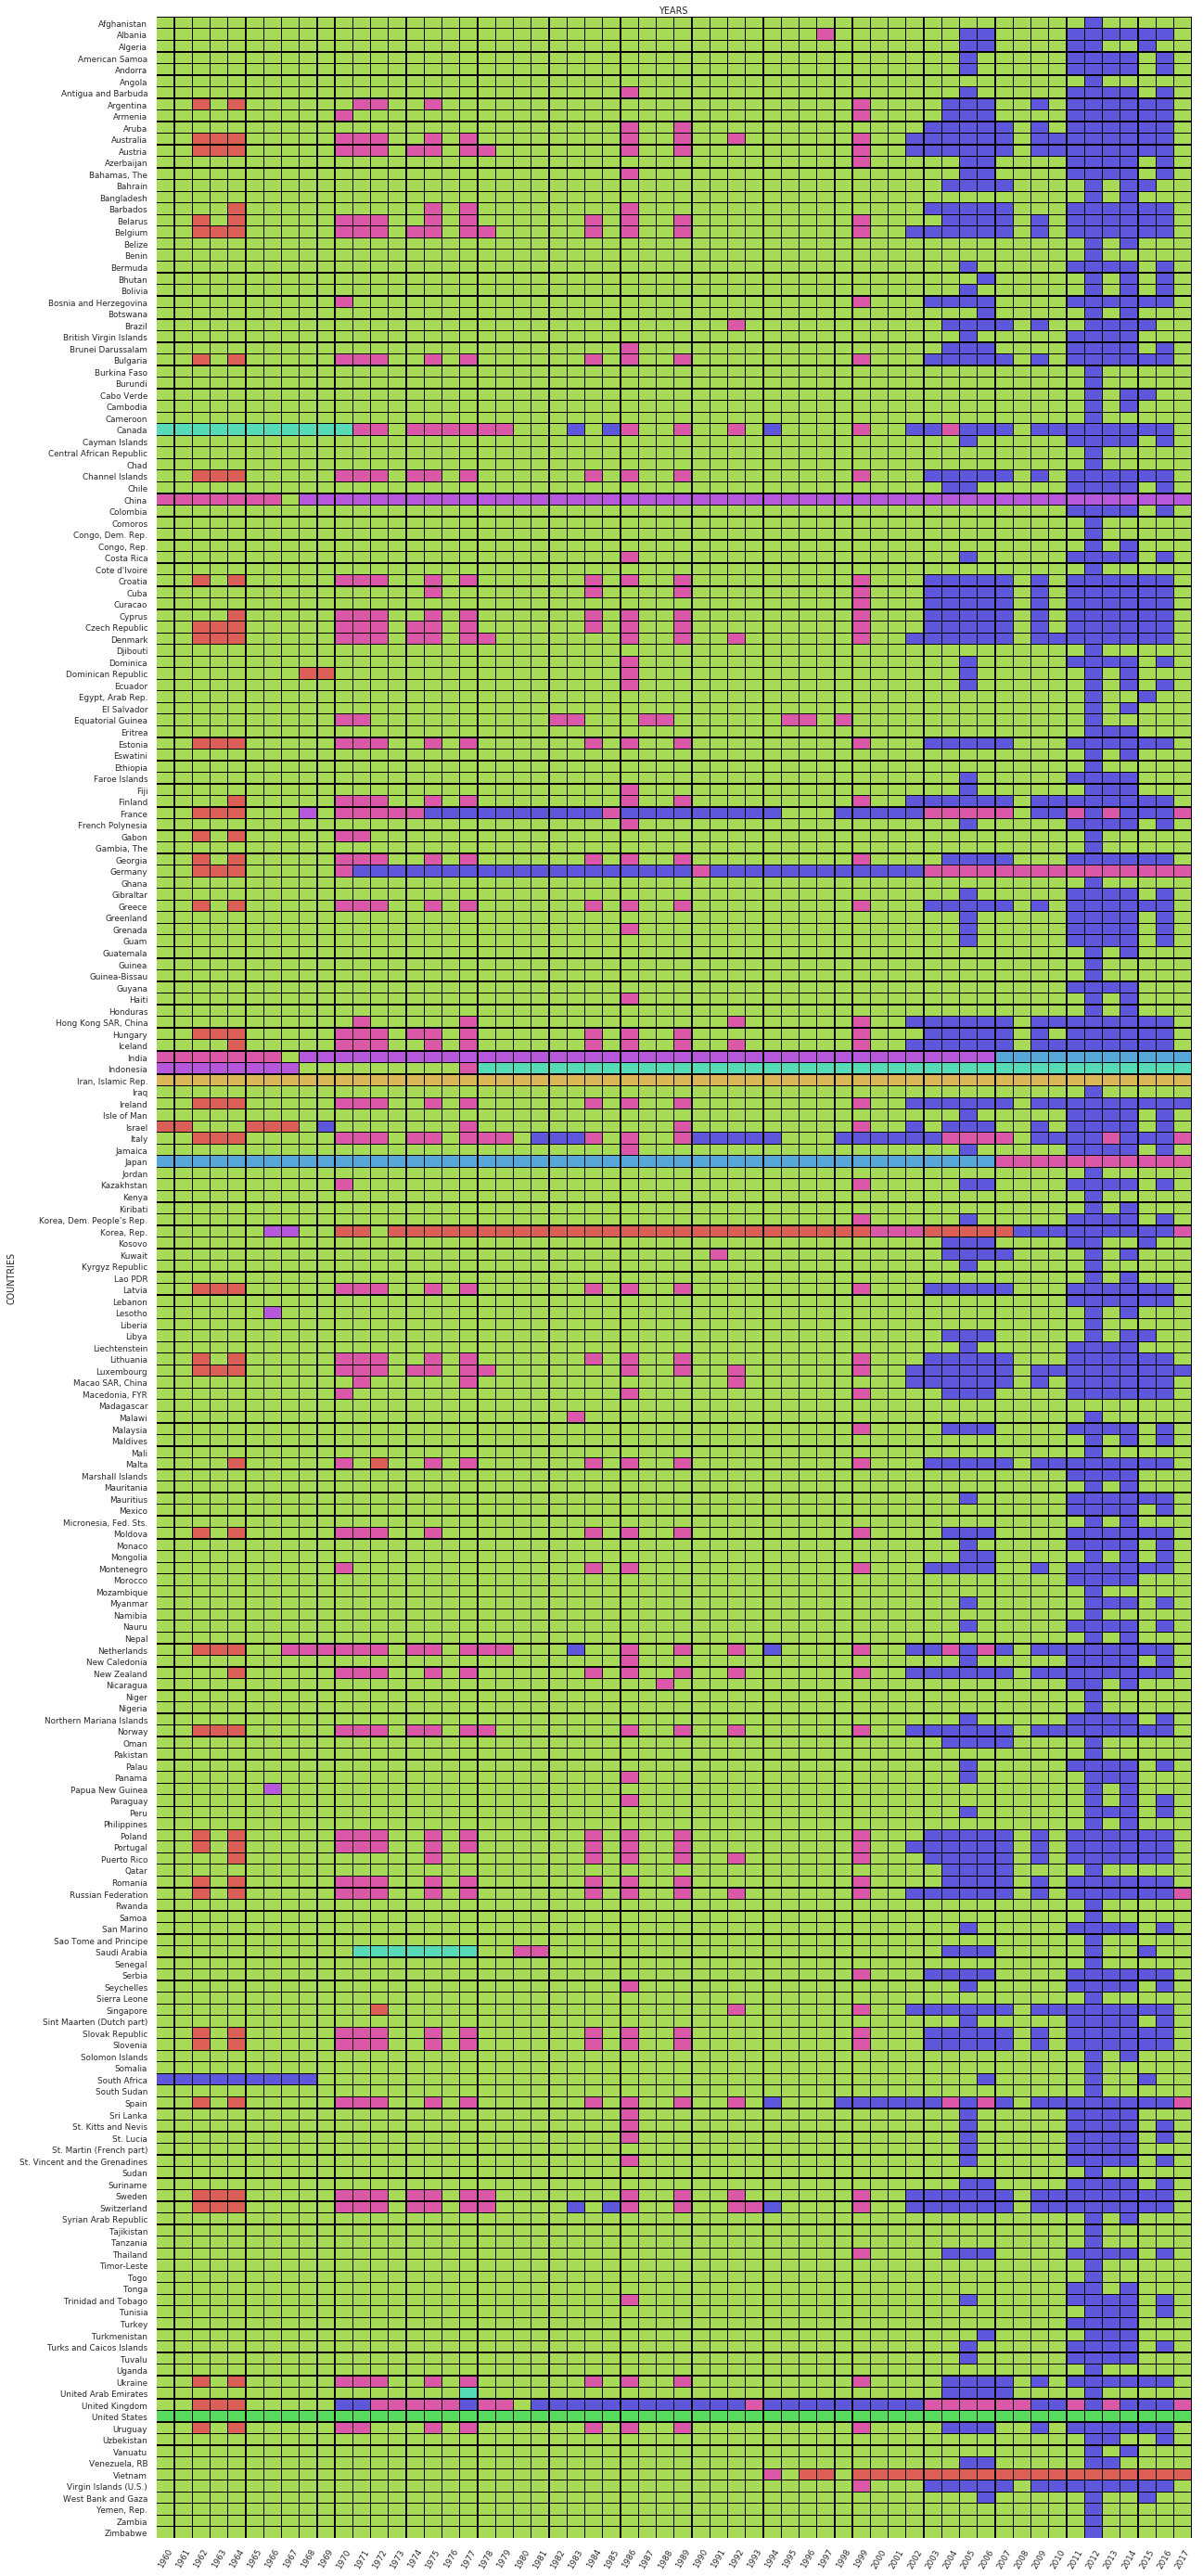

In [133]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

sns.set(font_scale=0.8, rc={'figure.figsize':(20,50)})
# менять этот сид чтобы перемешать цвета
np.random.seed(5)
cmap = np.random.permutation(sns.color_palette("hls", n_clusters))
cmap = [tuple(color) for color in cmap]
ax = sns.heatmap(clusters_labels.T, cmap=cmap, cbar=False, linewidths=.3, linecolor='black')

# X - Y axis labels
ax.set_ylabel('countries'.upper())
ax.set_xlabel('years'.upper())

ax.xaxis.set_label_position('top')
locs, labels = plt.xticks()
plt.xticks(locs, years)
locs, labels = plt.xticks()
plt.setp(labels, rotation=60)
locs, labels = plt.yticks()
plt.yticks(locs, country_names2codes(countries[47:]))

plt.show()

In [126]:
# Не переживайте, мне тоже было тяжело разобраться с данными

# Контрольные вопросы
Постарайтесь максимально развернуто и честно ответить на вопросы. Они охватывают тему алгоритмов кластеризации и скорее нужны преподавателям, чтобы понимать, что именно Вы усвоили плохо. Надеюсь, они подскажут, что именно в теме Вы не понимаете или наоборот порадают, что Вы все знаете ^_^

* Опишите, пожалуйста, для каких прикладных задач Вы бы стали использовать методы кластеризации?

***Ваше ответ здесь***

* Какие преимущества и недостатки Вы видите у следуюших алгоритмов кластеризации: kmeans, dbscan, агломеративная кластеризация?

***Ваше ответ здесь***

* На лекции было показано, что EM алгоритм находит оценку максимального правдоподобия в задаче со сккрытыми переменными. Из курса мат. статистики Вы можете знать, оценка максимального правдоподобия "оптимальная" во многих смыслах. В каких же случаях тогда не следует применять метод максимального правдоподобия?

***Ваше ответ здесь***

* Многие алгоритмы анализа данных страдают "проклятием" размерности. Страдают ли этим проклятием алгоритмы кластеризации? Если да, то как бы Вы с этим боролись?

***Ваше ответ здесь***

* Представьте, что у Вас есть набор текстовых документов, и Вы хотите разбить эти документы на тематики - новости, спорт, кулинария, кино и так далее. Размеченной выборки у Вас нет, только сами тексты документов. Какие алгоритмы и какие признаки Вы бы использовали для решения данной задачи?

***Ваше ответ здесь***

* Теперь представьте, что небольшая часть Ваших текстов была размечена людьми, но большая часть так и осталась без таргета. Смогли ли бы Вы использовать эти данные для улучения качества кластеризации? (эта задача называется semi-supervised learning)

***Ваше ответ здесь***

Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***